Note: *cudamat* is one option to do parallel computing for matrix computation

In [1]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.io import loadmat
import random
from numpy import linalg as LA
import time

from IPython import display
# from numbapro import vectorize

In [2]:
def window_filter_1d(n, s, xi, sigma):
    # generate one 1D gabor wavelet 
    x = np.arange(n)
    chi = np.zeros(n)
    chi[0:s] = 1
    o = np.exp(1j * xi * x)
#     o = np.exp(1j * xi/s * x)
    
    psi = np.multiply(chi, o)
    
    psi_hat = np.fft.fft(psi)
    return psi, psi_hat

def window_filter_family_1d(n, s, xi, sigma = 1):
    # generate a family of 1D gabor wavelets with specified scales and rotations in space
    ns = s.shape[0]
    nxi = xi.shape[0]
    
    psi = np.zeros((n, ns, nxi),dtype=complex)
    psi_hat = np.zeros((n, ns, nxi),dtype=complex)
    for i in range(ns):
        for k in range(nxi):
                psi[:, i, k], psi_hat[:, i, k] = window_filter_1d(n, int(s[i]), xi[k], sigma)
    return psi, psi_hat

def scat_coeff(x, g_hat):
    f = np.sum(np.abs(wave_trans_in_freq_1d(x, g_hat)), axis = 0)
    f = np.append(np.sum(x), f)
    return f

def wave_trans_in_freq_1d(x, psi_hat):
    # wavelet transform in frequency
    nx = x.shape
    
    x_hat = np.fft.fft(x)
    f = np.zeros(psi_hat.shape, dtype = complex)
    for i in range(psi_hat.shape[1]):
        f[:,i] = np.fft.ifft(np.multiply(x_hat, psi_hat[:,i]))
    return f

def determine_sigma(epsilon):
    sigma = np.sqrt(- 2 * np.log(epsilon)) / math.pi
    return sigma

def determine_J(N, Q, sigma, *alpha):
    if len(alpha) == 0:
        alpha = 3
    J = np.log2(N) - np.log2(alpha) - np.log2(sigma) - 1
    int_J = max(np.floor(J), 1);
    frac_J = (1/Q) * np.around((J - int_J) * Q);
    J = int_J + frac_J;
    return J

In [3]:

def diff(y0, sx, psi_hat, psi):
    # difference vector between first moment wavelet coefficients
    sy = scat_coeff(y0, psi_hat)
    diff = np.sum((sy - sx)**2)
    return diff


def synthesis(sx, x, psi_hat, psi, max_err, max_epoch, *args):
    # collect parameters
    nx = psi_hat.shape[0]
    nw = psi_hat.shape[1]  # number of wavelets 
    
    # randomly initialize new signal
    narg = len(args)
    if narg == 0:
        y0 = np.random.random(nx) 
    else:
        y0 = args[0]
    y = np.expand_dims(x, axis = 1)
    
    err = 1
    epoch = 0
    tic = time.time()
    while (epoch < max_epoch):
        
        epoch += 1
        ind = np.random.choice(nw, nw, replace = False) # randomize index of wavelets
        print('epoch:', epoch)
        
        for i in range(nw):
#             print('idx:',i)
            res = minimize(diff, y0, args = (sx[np.append([0], ind[0:i+1] + 1)], psi_hat[:,ind[0:i+1]], \
                                                         psi[:,ind[0:i+1]]), jac = jac, method='BFGS')
            y0 = res.x
            y = np.append(y, np.reshape(y0, (y0.shape[0], 1)), axis = 1)
            
            err = res.fun
            print('current error:', err)
        
    toc = time.time()
    print('running time: ', toc - tic)
    return y

def jac(y0, sx, psi_hat, psi):
    # jacobian function for difference
    epsilon = 1e-6
    n = psi_hat.shape[0]
    nw = psi_hat.shape[1]
    sy = scat_coeff(y0, psi_hat)
    y_hat = np.fft.fft(np.fft.fftshift(y0))
    
    g = np.zeros(n)
    
    psi_shift = np.zeros((n,n), dtype = complex)    
    
    g = g + 2 * (sy[0] - sx[0]) * np.ones(n)

    for i in range(nw):
        temp1 = np.fft.fftshift(np.fft.ifft(np.multiply(y_hat, psi_hat[:,i])))
        for p in range(n):
            psi_shift[:, p] = np.roll(psi[:,i], p, axis = 0)
        temp2 = np.matmul(np.divide(np.real(temp1), abs(temp1) + epsilon), np.real(psi_shift)) + \
                np.matmul(np.divide(np.imag(temp1), abs(temp1) + epsilon), np.imag(psi_shift))
        g = g + 2 * (sy[i+1] - sx[i+1]) * temp2
    return g

In [6]:
n = 2**7
pi = math.pi
max_err = 1e-7
max_epoch = 1

epsilon = 1e-7

# define filters
sigma = determine_sigma(epsilon)
Q = 2
alpha = 2
J = determine_J(n, Q, sigma, alpha) + 1
# s = np.unique(np.floor(2 ** np.linspace(1, J, int(J*Q)+1-Q)))
s = np.array([1,2,4,8,10,16,23,31,41,63,75,118])
# xi = 2 * pi * np.random.choice(n,1) / n
xi = np.array([3 * pi / 4, 23 * pi / 128]) # choose two frequencies
g, g_hat = window_filter_family_1d(n, s, xi) # use characteristic window function
g = np.reshape(g, (g.shape[0], -1))
g_hat = np.reshape(g_hat, (g_hat.shape[0], -1))
nwave = g_hat.shape[1]
dy = np.zeros(n)
ind_dirac = np.random.choice(int(n/2), 3, replace = False) * 2 # randomly select support
dy[ind_dirac] = 1

sx = scat_coeff(dy, g_hat)

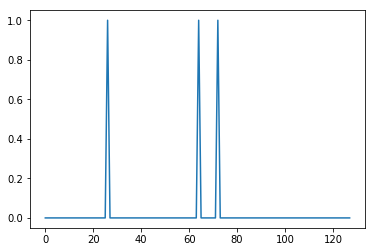

In [7]:
plt.plot(dy)

In [10]:
res = synthesis(sx, dy, g_hat, g, max_err, max_epoch)

epoch: 1
current error: 4.0990807157938066e-14
current error: 1.435536482177575e-14
current error: 2.0331880384869007e-14
current error: 2.6292407241138824e-06
current error: 4.2492346612975e-09
current error: 1.4199731796288755e-08
current error: 1.6174925346525867e-08
current error: 1.953886204477312e-08
current error: 1.4073845907024015e-08
current error: 1.4226246729036763e-08
current error: 0.006507399687962423
current error: 0.007413597584617674
current error: 1.1553692829355916e-07
current error: 1.5833958372452885e-08
current error: 1.1730847553254176e-08
current error: 5.49167069646299e-08
current error: 1.0624215008471614e-08
current error: 9.898965135927573e-09
current error: 1.1387529702451078e-08
current error: 1.1485585996231676e-08
current error: 1.9199160353744322e-08
current error: 1.3064413156571348e-08
current error: 4.144510810452987e-08
current error: 6.950161793823603e-09
running time:  218.03259086608887


Text(0.5,1,'synthesized signal')

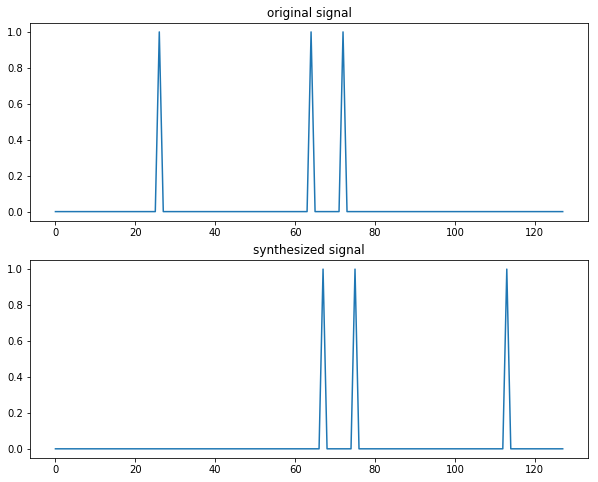

In [11]:
plt.figure(figsize = (10, 8))
plt.subplot(2,1,1)
plt.plot(dy) # target signal
plt.title('original signal')
ax2 = plt.subplot(2,1,2)
plt.plot(res[:, -1])
plt.title('synthesized signal')
# plt.savefig('syn_bump')

In [12]:
y0 = res[:,-1]
x = res[:,0]
sy = np.sum(np.abs(wave_trans_in_freq_1d(y0, g_hat)), axis = 0)
# sy = np.append(np.sum(np.abs(y0)), sy)
sy = np.append(np.sum(y0), sy)
print('scattering of target:', sx)
print('scattering of synthesized:', sy)
print('scattering difference with wavelets in optimization process:', np.sum((sy - sx)**2))

scattering of target: [  3.           3.           3.           6.           6.
  12.          12.          24.          24.          30.
  28.53757314  48.          42.15029255  69.          58.03179852
  93.          76.18209107 121.24264069  94.4702333  171.32686412
 123.91024834 198.15967985 141.86009866 268.23421475 181.49123054]
scattering of synthesized: [  2.99998167   3.00003023   3.00003023   6.00002769   6.00003021
  12.00000919  12.00001186  24.00001167  23.99999258  30.00001363
  28.53756958  48.00001231  42.15029641  69.00000679  58.03180095
  92.99999093  76.18208642 121.24263618  94.47022609 171.32688861
 123.91026489 198.15964686 141.86008964 268.23422204 181.49123009]
scattering difference with wavelets in optimization process: 6.950161793823603e-09
